In [421]:
# !pip install wordcloud

In [422]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [423]:
# Importing the dataset
DATASET_COLUMNS=['Index','Date','Target','Id','Tweet']
DATASET_ENCODING = "ISO-8859-1"
df = pd.read_csv('Dataset.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,Index,Date,Target,Id,Tweet
4503,47,2022-03-28 10:00:07+00:00,0,1.508383e+18,Our next Evening Medical Update on 26 April is...
1088,1088,2022-03-04 10:40:11+00:00,2,1.499700e+18,The 2022 Bennetts British Superbike Championsh...
4154,98,2022-03-28 06:29:39+00:00,4,1.508330e+18,Slot 7 Bring me a selfie of you with light bulb
1726,1726,2022-03-04 18:06:08+00:00,4,1.499810e+18,Hackers issue bizarre demand to NVDIA Let us m...
3176,6,2022-03-14 10:25:34+00:00,4,1.503316e+18,A Cerv lo P5 for 10 Triathlete raffles off TT ...


In [424]:
df.head()

,Index,Date,Target,Id,Tweet
0,0,2022-03-06 06:31:01+00:00,0,1.500360e+18,Debunking the Skin Improvement Myth Product re...
1,1,2022-03-06 06:18:31+00:00,2,1.500360e+18,We get your concern regarding the offer of the...
2,2,2022-03-06 06:07:41+00:00,4,1.500350e+18,Thinking about buying Mr Peanut s Gold Series ...
3,3,2022-03-06 06:07:36+00:00,4,1.500350e+18,Thinking about buying Mr Peanut s Gold Series ...
4,4,2022-03-06 06:00:08+00:00,0,1.500350e+18,Clinical Pathology Interpretations Fourth Edit...


In [425]:
df.columns

Index(['Index', 'Date', 'Target', 'Id', 'Tweet'], dtype='object')

In [426]:
print('length of data is', len(df))

length of data is 5077


In [427]:
df.shape

(5077, 5)

In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5077 entries, 0 to 5076
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Index   5077 non-null   int64  
 1   Date    5077 non-null   object 
 2   Target  5077 non-null   int64  
 3   Id      5077 non-null   float64
 4   Tweet   5076 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 198.4+ KB


In [429]:
df.dtypes

Index       int64
Date       object
Target      int64
Id        float64
Tweet      object
dtype: object

In [430]:
np.sum(df.isnull().any(axis=1))

1

In [431]:
print('Count of columns in the data is:  ', len(df.columns))
print('Count of rows in the data is:  ', len(df))

Count of columns in the data is:   5
Count of rows in the data is:   5077


In [432]:
df['Target'].unique()

array([0, 2, 4])

In [433]:
df['Target'].nunique()

3

In [434]:
ax = df.groupby('Target').count()
print(ax)

        Index  Date    Id  Tweet
Target                          
0        3150  3150  3150   3149
2         662   662   662    662
4        1265  1265  1265   1265


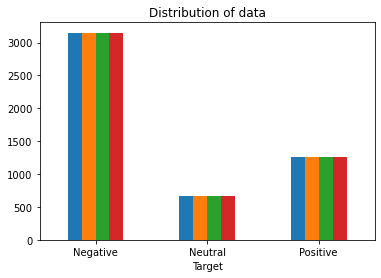

In [435]:
# Plotting the distribution for dataset.
ax = df.groupby('Target').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Neutral','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(df['Tweet']), list(df['Target'])

<AxesSubplot:xlabel='Target', ylabel='count'>

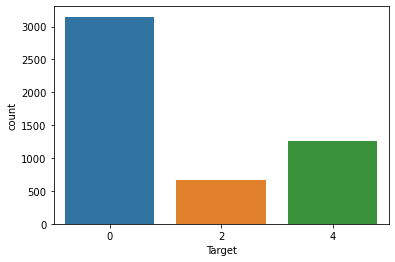

In [436]:
import seaborn as sns
sns.countplot(x='Target', data=df)

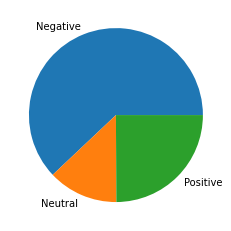

In [437]:
#we can add explode parameter to pop out the different sections of our pie chart
#remove explode parameter for a normal pie chart

ax = df.groupby('Target').count()
plt.pie(ax['Index'], labels = ['Negative', 'Neutral', 'Positive'])
plt.show()

In [438]:
data=df[['Target', 'Tweet']]

In [439]:
data['Target'] = data['Target'].replace(4,1)

/tmp/ipykernel_6447/778994191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data['Target'].replace(4,1)


In [440]:
data['Target'].unique()

array([0, 2, 1])

In [441]:
data_neg = data[data['Target'] == -1]
data_neu = data[data['Target'] == 0]
data_pos = data[data['Target'] == 1]

In [442]:
dataset = pd.concat([data_neg, data_neu, data_pos])

In [443]:
dataset['Tweet']=dataset['Tweet'].str.lower()
dataset['Tweet'].tail()

5047    he laughed in disgust and thought watch this m...
5062       i got literal plot armor superman lmao lets go
5064    thoughts on will smith congrats on winning osc...
5069    lmao his wife that paragon of virture virtue r...
5075    and it was surreal listening to him make richa...
Name: Tweet, dtype: object

In [444]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [445]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['Tweet'] = dataset['Tweet'].apply(lambda text: cleaning_stopwords(text))
dataset['Tweet'].head()

0    debunking skin improvement myth product review...
4    clinical pathology interpretations fourth edit...
5    organic roasted seaweed snack costco product r...
6    bare lightly breaded chicken breast chunks cos...
7    chipotle bitchin sauce organic almond dip cost...
Name: Tweet, dtype: object

In [446]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['Tweet']= dataset['Tweet'].apply(lambda x: cleaning_punctuations(x))
dataset['Tweet'].tail()

5047                  laughed disgust thought watch mf er
5062         got literal plot armor superman lmao lets go
5064    thoughts smith congrats winning oscar much har...
5069    lmao wife paragon virture virtue running crips...
5075    surreal listening make richard williams parago...
Name: Tweet, dtype: object

In [447]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: cleaning_repeating_char(x))
dataset['Tweet'].tail()

5047                  laughed disgust thought watch mf er
5062         got literal plot armor superman lmao lets go
5064    thoughts smith congrats winning oscar much har...
5069    lmao wife paragon virture virtue running crips...
5075    surreal listening make richard williams parago...
Name: Tweet, dtype: object

In [448]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: cleaning_URLs(x))
dataset['Tweet'].tail()

5047                  laughed disgust thought watch mf er
5062         got literal plot armor superman lmao lets go
5064    thoughts smith congrats winning oscar much har...
5069    lmao wife paragon virture virtue running crips...
5075    surreal listening make richard williams parago...
Name: Tweet, dtype: object

In [449]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: cleaning_numbers(x))
dataset['Tweet'].tail()

5047                  laughed disgust thought watch mf er
5062         got literal plot armor superman lmao lets go
5064    thoughts smith congrats winning oscar much har...
5069    lmao wife paragon virture virtue running crips...
5075    surreal listening make richard williams parago...
Name: Tweet, dtype: object

In [450]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("[\w']+")
dataset['Tweet'] = dataset['Tweet'].apply(tokenizer.tokenize)
dataset['Tweet'].head()

0    [debunking, skin, improvement, myth, product, ...
4    [clinical, pathology, interpretations, fourth,...
5    [organic, roasted, seaweed, snack, costco, pro...
6    [bare, lightly, breaded, chicken, breast, chun...
7    [chipotle, bitchin, sauce, organic, almond, di...
Name: Tweet, dtype: object

In [451]:
import nltk
# !nltk.download('wordnet')
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['Tweet']= dataset['Tweet'].apply(lambda x: stemming_on_text(x))
dataset['Tweet'].head()

0    [debunking, skin, improvement, myth, product, ...
4    [clinical, pathology, interpretations, fourth,...
5    [organic, roasted, seaweed, snack, costco, pro...
6    [bare, lightly, breaded, chicken, breast, chun...
7    [chipotle, bitchin, sauce, organic, almond, di...
Name: Tweet, dtype: object

In [452]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['Tweet'] = dataset['Tweet'].apply(lambda x: lemmatizer_on_text(x))
dataset['Tweet'].head()

0    [debunking, skin, improvement, myth, product, ...
4    [clinical, pathology, interpretations, fourth,...
5    [organic, roasted, seaweed, snack, costco, pro...
6    [bare, lightly, breaded, chicken, breast, chun...
7    [chipotle, bitchin, sauce, organic, almond, di...
Name: Tweet, dtype: object

In [453]:
X=data.Tweet
y=data.Target

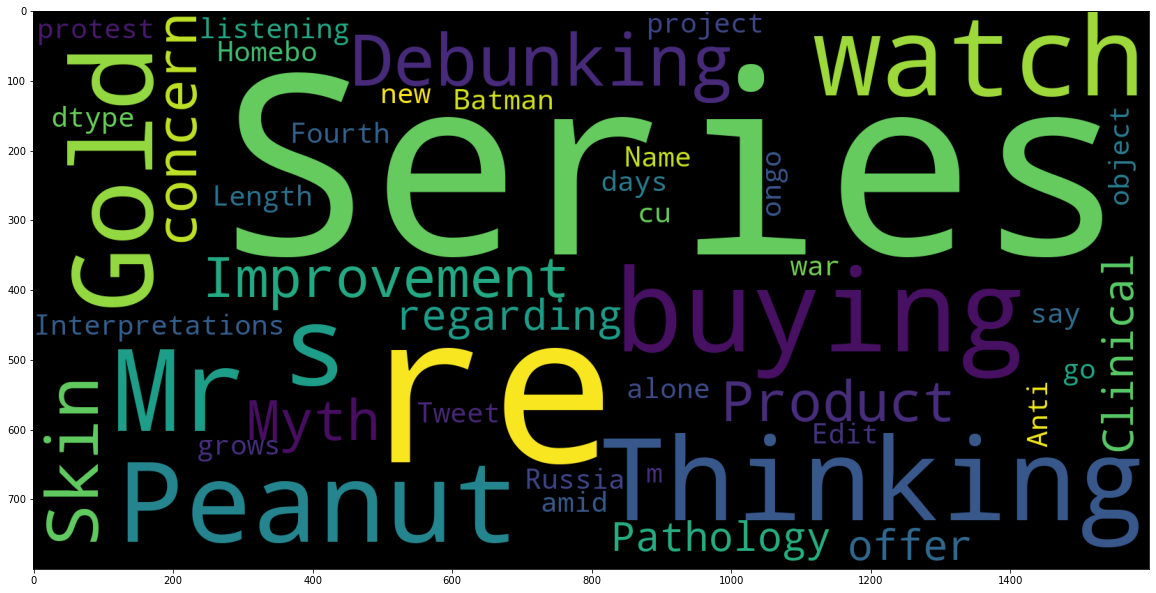

In [454]:
data_neg = data['Tweet'][:3150]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate("".join(str(data_neg)))
plt.imshow(wc)

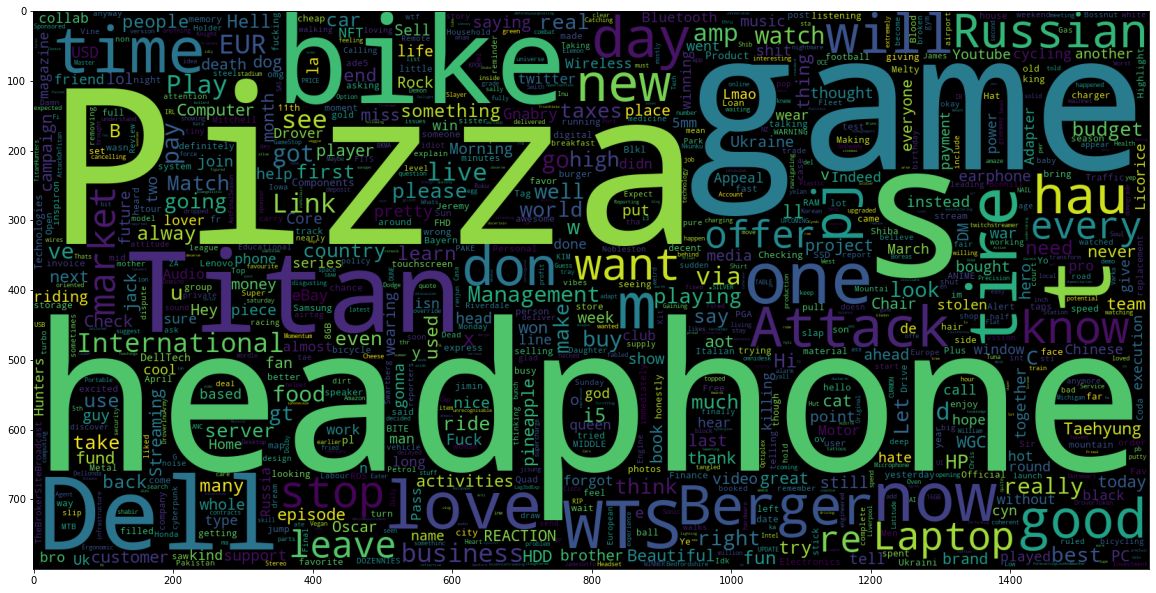

In [455]:
data_neu = data['Tweet'][3150:3812]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(" ".join(data_neu))
plt.figure(figsize = (20,20))
plt.imshow(wc)

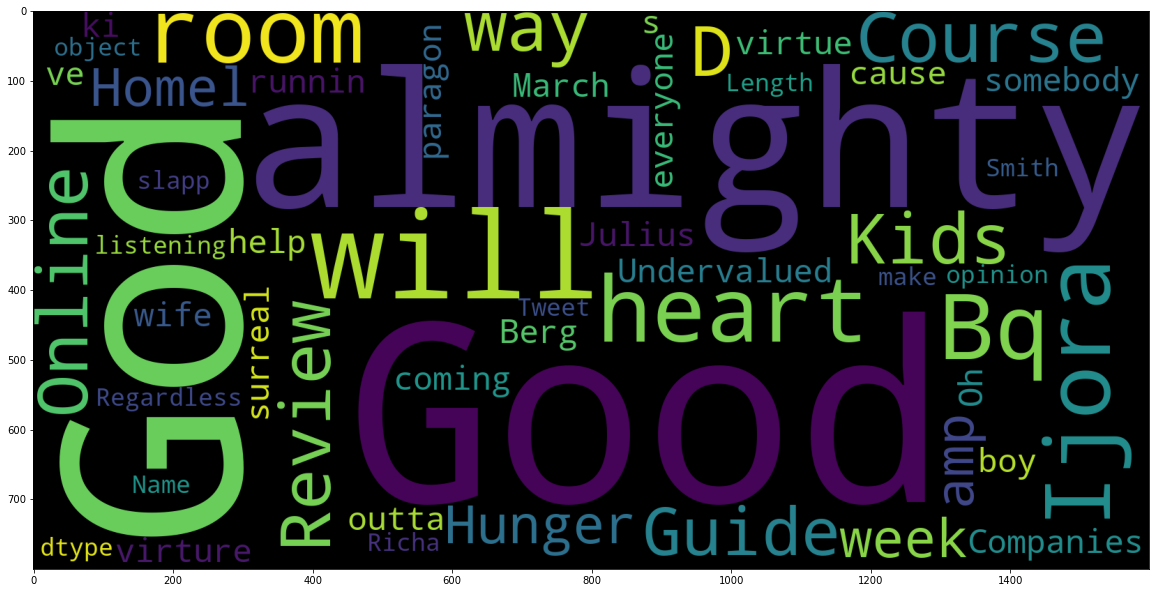

In [456]:
data_pos = data['Tweet'][3812:5077]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate("".join(str(data_pos)))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [457]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =11000)

In [458]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=6000)
vectoriser.fit(X_train.values.astype('U'))
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  6000


In [459]:
X_train = vectoriser.transform(X_train.values.astype('U'))
X_test  = vectoriser.transform(X_test.values.astype('U'))

In [460]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Neutral','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)